In [95]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

pd.set_option('display.max_columns', None)

import os

import torch
from torch.utils.data import Dataset, DataLoader

from catboost import CatBoostClassifier

import pickle

In [ ]:
output_dir = "processed_batches"
os.makedirs(output_dir, exist_ok=True)

In [3]:
df_1 = pd.read_csv("/kaggle/input/hack-pfo/train_data/cntrbtrs_clnts_ops_trn.csv", sep=';', encoding="cp1251")
df_2 = pd.read_csv("/kaggle/input/hack-pfo/train_data/trnsctns_ops_trn.csv", sep=';', encoding="cp1251")

/tmp/ipykernel_30/1913206868.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv("/kaggle/input/hack-pfo/train_data/cntrbtrs_clnts_ops_trn.csv", sep=';', encoding="cp1251")


In [4]:
tr_dummies = pd.get_dummies(df_2[['cmmnt', 'sum_type', 'mvmnt_type']])

In [5]:
df_2 = df_2.drop(['cmmnt', 'sum_type', 'mvmnt_type'], axis=1).join(tr_dummies)

In [6]:
df_2_grouped = df_2.groupby('accnt_id').sum()

In [7]:
df_merged = df_1.merge(df_2_grouped, on='accnt_id', how='left')

In [8]:
class CustomDataset(Dataset):
    def __init__(self, df, scaler):
        self.df = df
        self.scaler = scaler
        self.df['age_group'] = (self.df['prsnt_age'] // 5) * 5
        self.df = pd.get_dummies(self.df, columns=['gndr', 'accnt_status', 'addrss_type', 'rgn', 'phn',
                                                   'email', 'lk', 'assgn_npo', 'assgn_ops'], 
                                 drop_first=True)
        self.df.replace({True: 1, False: 0}, inplace=True)
        self.df.drop(columns=['slctn_nmbr', 'clnt_id', 'accnt_id', 'prsnt_age', 'accnt_bgn_date',
                              'prvs_npf', 'brth_plc', 'dstrct',
                              'city', 'sttlmnt', 'pstl_code', 'okato', 'oprtn_date'], inplace=True)
        self.df[['sum', 'cprtn_prd_d', 'pnsn_age']] = self.scaler.fit_transform(self.df[['sum', 'cprtn_prd_d', 'pnsn_age']])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return torch.tensor(row.values, dtype=torch.float32)

scaler = StandardScaler()

dataset = CustomDataset(df_merged, scaler)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

batch_num = 0

for batch in tqdm(dataloader):

    batch_df = pd.DataFrame(batch.numpy(), columns=dataset.df.columns)

    batch_file = os.path.join(output_dir, f"batch_{batch_num}.csv")
    batch_df.to_csv(batch_file, index=False)

    batch_num += 1
    
    del batch_df, batch

100%|██████████| 2082/2082 [02:50<00:00, 12.21it/s]


In [9]:
all_batches = [pd.read_csv(os.path.join(output_dir, f)) for f in os.listdir(output_dir) if f.endswith(".csv")]
df_merged_prepared = pd.concat(all_batches, ignore_index=True)

df_merged_prepared.to_csv("df_merged_prepared.csv", index=False)

In [10]:
df_merged_prepared.shape

(532825, 148)

In [17]:
df_merged_prepared.head()

,brth_yr,cprtn_prd_d,erly_pnsn_flg,pnsn_age,sum,mvmnt_type,cmmnt_Возврат выплаченных сумм (ОПС),cmmnt_Восполнение (ОПС),cmmnt_Закрытие договора ОПС,cmmnt_Компенсация(ОПС),cmmnt_Корректировка записей регистров (ОПС),cmmnt_Назначение пенсии (ОПС),cmmnt_Начисление (ОПС),cmmnt_Начисление пенсии (ОПС),cmmnt_Перевод в резерв Фонда (ОПС),cmmnt_Перевод между счетами ОПС,cmmnt_Передача СПН в другой фонд по Уведомлениям ПФР о разделении ИЛС (ОПС),cmmnt_Поступление взносов ОПС,cmmnt_Приостановление/возобновление/прекращение выплат пенсии (ОПС),cmmnt_Распределение ИД ОПС,cmmnt_Решение о единовременной выплате (ОПС),sum_type_Взносы работодателя (ДСВ2),sum_type_Взносы софинансирование,sum_type_Выплатной резерв НЧ,sum_type_Выплатной резерв СВ,sum_type_Доп. страховые взносы (ДСВ1),sum_type_ИД Выплатной резерв НЧ,sum_type_ИД Выплатной резерв СВ,sum_type_ИД на взносы работодателя (ИД ДСВ2),sum_type_ИД на доп. взносы (ИД ДСВ1),sum_type_ИД на материнский капитал,sum_type_ИД на софинансирование,sum_type_ИД на страховые взносы на НЧ,sum_type_Материнский капитал,sum_type_РФОПС,sum_type_Страховые взносы на НЧ,age_group,gndr_м,accnt_status_Накопительный период,addrss_type_Адрес за пределами РФ,addrss_type_Адрес места жительства,addrss_type_Адрес по прописке,rgn_АЛТАЙ РЕСП,rgn_АЛТАЙСКИЙ КРАЙ,rgn_АМУРСКАЯ ОБЛ,rgn_АРХАНГЕЛЬСКАЯ ОБЛ,rgn_АСТРАХАНСКАЯ ОБЛ,rgn_БАЙКОНУР Г,rgn_БАШКОРТОСТАН РЕСП,rgn_БЕЛАРУСЬ,rgn_БЕЛГОРОДСКАЯ ОБЛ,rgn_БРЯНСКАЯ ОБЛ,rgn_БУРЯТИЯ РЕСП,rgn_ВЛАДИМИРСКАЯ ОБЛ,rgn_ВОЛГОГРАДСКАЯ ОБЛ,rgn_ВОЛОГОДСКАЯ ОБЛ,rgn_ВОРОНЕЖСКАЯ ОБЛ,rgn_Г МОСКВА,rgn_ДАГЕСТАН РЕСП,rgn_ДОНЕЦКАЯ НАРОДНАЯ РЕСП,rgn_ЕВРЕЙСКАЯ АОБЛ,rgn_ЗАБАЙКАЛЬСКИЙ КРАЙ,rgn_ЗАПОРОЖСКАЯ ОБЛ,rgn_ИВАНОВСКАЯ ОБЛ,rgn_ИНГУШЕТИЯ РЕСП,rgn_ИРКУТСКАЯ ОБЛ,rgn_КАБАРДИНО-БАЛКАРСКАЯ РЕСП,rgn_КАЗАХСТАН,rgn_КАЛИНИНГРАДСКАЯ ОБЛ,rgn_КАЛМЫКИЯ РЕСП,rgn_КАЛУЖСКАЯ ОБЛ,rgn_КАМЧАТСКИЙ КРАЙ,rgn_КАРАЧАЕВО-ЧЕРКЕССКАЯ РЕСП,rgn_КАРЕЛИЯ РЕСП,rgn_КЕМЕРОВСКАЯ ОБЛ,rgn_КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,rgn_КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС ОБЛ,rgn_КИРОВСКАЯ ОБЛ,rgn_КОМИ РЕСП,rgn_КОСТРОМСКАЯ ОБЛ,rgn_КРАСНОДАРСКИЙ КРАЙ,rgn_КРАСНОЯРСКИЙ КРАЙ,rgn_КРЫМ РЕСП,rgn_КУРГАНСКАЯ ОБЛ,rgn_КУРСКАЯ ОБЛ,rgn_ЛЕНИНГРАДСКАЯ ОБЛ,rgn_ЛИПЕЦКАЯ ОБЛ,rgn_МАГАДАНСКАЯ ОБЛ,rgn_МАРИЙ ЭЛ РЕСП,rgn_МОРДОВИЯ РЕСП,rgn_МОСКВА Г,rgn_МОСКОВСКАЯ ОБЛ,rgn_МУРМАНСКАЯ ОБЛ,rgn_НЕНЕЦКИЙ АО,rgn_НЕФТЕГОРСКИЙ,rgn_НИЖЕГОРОДСКАЯ ОБЛ,rgn_НОВГОРОДСКАЯ ОБЛ,rgn_НОВОСИБИРСКАЯ ОБЛ,rgn_ОМСКАЯ ОБЛ,rgn_ОРЕНБУРГСКАЯ ОБЛ,rgn_ОРЛОВСКАЯ ОБЛ,rgn_ПЕНЗЕНСКАЯ ОБЛ,rgn_ПЕРМСКИЙ КРАЙ,rgn_ПРИМОРСКИЙ КРАЙ,rgn_ПСКОВСКАЯ ОБЛ,rgn_РЕСП БАШКОРТОСТАН,rgn_РЕСП КАРЕЛИЯ,rgn_РОСТОВСКАЯ ОБЛ,rgn_РЯЗАНСКАЯ ОБЛ,rgn_САМАРСКАЯ ОБЛ,rgn_САНКТ-ПЕТЕРБУРГ Г,rgn_САРАТОВСКАЯ ОБЛ,rgn_САХА /ЯКУТИЯ/ РЕСП,rgn_САХАЛИНСКАЯ ОБЛ,rgn_СВЕРДЛОВСКАЯ ОБЛ,rgn_СЕВАСТОПОЛЬ Г,rgn_СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ РЕСП,rgn_СЕРГИЕВСКИЙ,rgn_СМОЛЕНСКАЯ ОБЛ,rgn_СТАВРОПОЛЬСКИЙ КРАЙ,rgn_ТАМБОВСКАЯ ОБЛ,rgn_ТАТАРСТАН РЕСП,rgn_ТВЕРСКАЯ ОБЛ,rgn_ТОМСКАЯ ОБЛ,rgn_ТУЛЬСКАЯ ОБЛ,rgn_ТЫВА РЕСП,rgn_ТЮМЕНСКАЯ ОБЛ,rgn_УДМУРТСКАЯ РЕСП,rgn_УКРАИНА,rgn_УЛЬЯНОВСКАЯ ОБЛ,rgn_ХАБАРОВСКИЙ КРАЙ,rgn_ХАКАСИЯ РЕСП,rgn_ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО,rgn_ХАНТЫ-МАНСИЙСКИЙ АО,rgn_ХАНТЫ-МАНСИЙСКИЙ-ЮГРА АО,rgn_ЧЕЛЯБИНСКАЯ ОБЛ,rgn_ЧЕЧЕНСКАЯ РЕСП,rgn_ЧУВАШСКАЯ РЕСП,rgn_ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ,rgn_ЧУВАШСКАЯ РЕСПУБЛИКА ЧУВАШИЯ,rgn_ЧУКОТСКИЙ АО,rgn_ЯМАЛО-НЕНЕЦКИЙ АО,rgn_ЯРОСЛАВСКАЯ ОБЛ,phn_нет,email_нет,lk_нет,assgn_npo_нет,assgn_ops_нет
0,1960.0,-0.177403,0.0,-0.807748,1.409013,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,0.0,39.0,33.0,0.0,10.0,0.0,0.0,21.0,0.0,0.0,0.0,31.0,0.0,20.0,31.0,0.0,0.0,20.0,60.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,1960.0,-0.005289,0.0

In [18]:
X = df_merged_prepared.drop(columns=['erly_pnsn_flg'])
y = df_merged_prepared['erly_pnsn_flg']

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(372977, 147) (159848, 147) (372977,) (159848,)


In [21]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0')

In [22]:
model.fit(X_train, y_train)

Learning rate set to 0.024341
0:	learn: 0.5961517	total: 18.7s	remaining: 5h 11m 54s
1:	learn: 0.4984241	total: 18.7s	remaining: 2h 35m 51s
2:	learn: 0.4132697	total: 18.7s	remaining: 1h 43m 51s
3:	learn: 0.3396524	total: 18.8s	remaining: 1h 17m 50s
4:	learn: 0.2902021	total: 18.8s	remaining: 1h 2m 14s
5:	learn: 0.2414979	total: 18.8s	remaining: 51m 49s
6:	learn: 0.2005482	total: 18.8s	remaining: 44m 23s
7:	learn: 0.1668402	total: 18.8s	remaining: 38m 49s
8:	learn: 0.1389961	total: 18.8s	remaining: 34m 29s
9:	learn: 0.1158202	total: 18.8s	remaining: 31m 1s
10:	learn: 0.0973777	total: 18.8s	remaining: 28m 10s
11:	learn: 0.0799360	total: 18.8s	remaining: 25m 49s
12:	learn: 0.0676202	total: 18.8s	remaining: 23m 48s
13:	learn: 0.0576477	total: 18.8s	remaining: 22m 6s
14:	learn: 0.0490318	total: 18.8s	remaining: 20m 36s
15:	learn: 0.0418192	total: 18.8s	remaining: 19m 18s
16:	learn: 0.0362988	total: 18.9s	remaining: 18m 9s
17:	learn: 0.0304533	total: 18.9s	remaining: 17m 8s
18:	learn: 0.026

In [23]:
preds_class = model.predict(X_val)

In [102]:
df_y = pd.DataFrame(({'y_val': y_val, 'preds_class': preds_class}))
df_y.to_csv('pred.csv', index=False)

In [28]:
f_1 = f1_score(y_val, preds_class)
f_1

0.996933321650749

In [89]:
confusion = confusion_matrix(y_val, preds_class)

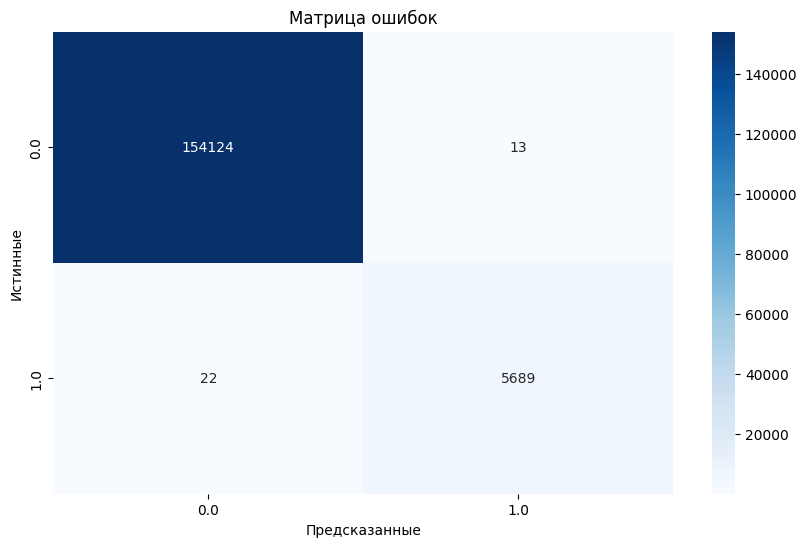

In [99]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.title('Матрица ошибок')
plt.savefig("conf.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [55]:
feature_importances = model.feature_importances_
feature_names = model.feature_names_
df = pd.DataFrame(({'feature_names': feature_names, 'feature_importances': feature_importances}))
df = df.sort_values(by='feature_importances', ascending=False)

,feature_names,feature_importances
0,brth_yr,47.421018
3,sum,8.259966
2,pnsn_age,7.512265
30,sum_type_ИД на софинансирование,7.099939
37,accnt_status_Накопительный период,6.918149
...,...,...
33,sum_type_РФОПС,0.000000
13,cmmnt_Перевод в резерв Фонда (ОПС),0.000000
11,cmmnt_Начисление (ОПС),0.000000
17,cmmnt_Приостановление/возобновление/прекращени...,0.000000


In [56]:
top_10_df = df.head(10)

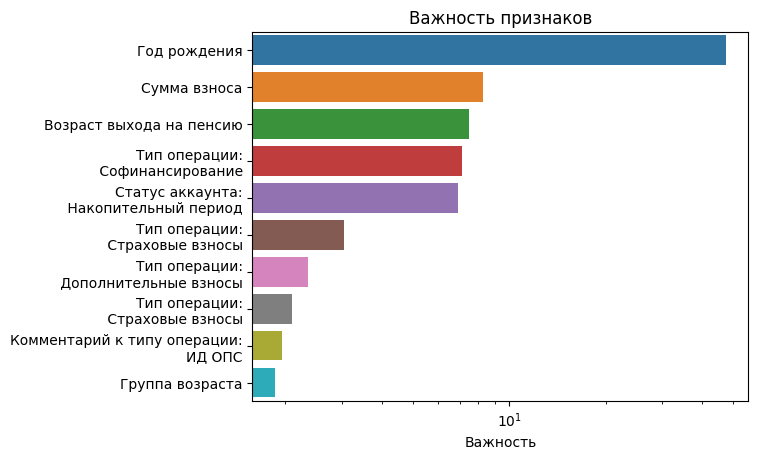

In [93]:
#my_palette = ["#FF0000", "#00FF00", "#0000FF"]
sns.barplot(x='feature_importances', y='feature_names', data=top_10_df, orient='h', palette='tab10')
plt.title("Важность признаков")
plt.xlabel("Важность")
plt.ylabel(None)
plt.yticks(np.arange(10), ['Год рождения', 'Сумма взноса', 'Возраст выхода на пенсию','Тип операции:\n Софинансирование', 'Статус аккаунта:\n Накопительный период', 'Тип операции:\n Страховые взносы', 'Тип операции:\n Дополнительные взносы', 'Тип операции:\n Страховые взносы', 'Комментарий к типу операции:\nИД ОПС', 'Группа возраста'])
plt.xscale('log')
plt.savefig("out_6.png", dpi=300, bbox_inches='tight')
plt.show()

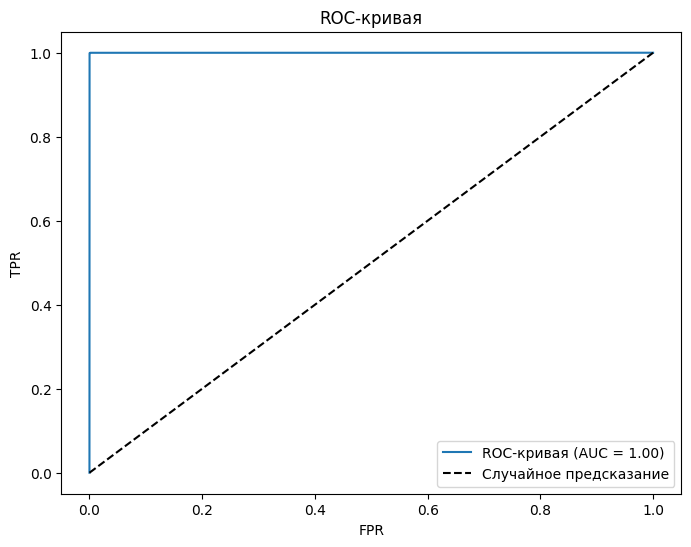

In [98]:
fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC-кривая (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Случайное предсказание')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.savefig("roc.png", dpi=300, bbox_inches='tight')
plt.show()